In [2]:
# ruff: noqa
import sys, os
sys.path.append(os.path.abspath("./../../feedback-grape"))
sys.path.append(os.path.abspath("./../../"))
sys.path.append(os.path.abspath("./../"))


# ruff: noqa
from feedback_grape.fgrape import evaluate_on_longer_time, Gate
from feedback_grape.utils.operators import (
    identity,
)
from feedback_grape.utils.states import (
    basis,
)
from helpers import (
    init_first_gate,
    init_T_half_gate,
    init_ptrace_gate,
    init_decay_gate,
    generate_random_bloch_state,
)
import jax
import jax.numpy as jnp
import numpy as np
from tqdm import tqdm

n = 2 # Number of qubits
N_chains = 2 # Number of chains
gamma = 0.25 # Decay rate
eval_time_steps = 100 # Number of time steps for evaluation
eval_batch_size = 16 # Batch size for evaluation

# Selection of states and operators
def negative(M):
    return jnp.sqrt(identity(M.shape[0]) - M)

psi_00 = basis(4, 3)
psi_01 = basis(4, 2)
psi_10 = basis(4, 1)
psi_11 = basis(4, 0)
I = identity(4)
O = jnp.zeros((4,4))
P_00 = psi_00 @ psi_00.conj().T
P_01 = psi_01 @ psi_01.conj().T
P_10 = psi_10 @ psi_10.conj().T
P_11 = psi_11 @ psi_11.conj().T


# Error correction protocol to test
protocols = [
    {
        "label": "Zeno effect |00><00|",
        "povm_init_p": negative(P_00),
        "povm_init_m": P_00,
        "povm_p_p": negative(P_00),
        "povm_p_m": P_00,
        "povm_m_p": negative(P_00),
        "povm_m_m": P_00,
        "U_p": I,
        "U_m": I,
    },
    {
        "label": "Avoid |00><00|",
        "povm_init_p": I,
        "povm_init_m": O,
        "povm_p_p": negative(P_00),
        "povm_p_m": P_00,
        "povm_m_p": I,
        "povm_m_m": O,
        "U_p": I, # When not in |00>, do nothing
        "U_m": (
            1/2**0.5*(psi_01 + psi_10) @ (psi_00).conj().T # |00> --> (|01> + |10>)/sqrt(2)
            + 1/2**0.5*psi_11@(psi_01 + psi_10).conj().T # (|01> + |10>)/sqrt(2) --> |11>
            + 1/2**0.5*(psi_01 - psi_10)@psi_11.conj().T # (|11> --> |01> - |10>)/sqrt(2)
            + 1/2**0.5*psi_00@(psi_01 - psi_10).conj().T # (|01> - |10>)/sqrt(2) --> |00>
        )
    }
]

# Validate parameters
def check_povm(povm_p, povm_m):
    assert jnp.allclose(povm_p.conj().T @ povm_p + povm_m.conj().T @ povm_m, identity(povm_p.shape[0])), "Povm operators do not sum to identity."
def check_unitary(U):
    assert jnp.allclose(U.conj().T @ U, identity(U.shape[0])), "Unitary operator is not unitary."

for i, protocol in enumerate(protocols):
    check_povm(protocol["povm_init_p"], protocol["povm_init_m"])
    check_povm(protocol["povm_p_p"], protocol["povm_p_m"])
    check_povm(protocol["povm_m_p"], protocol["povm_m_m"])
    check_unitary(protocol["U_p"])
    check_unitary(protocol["U_m"])

In [3]:
# Construct lookup table for protocol
def lut_from_protocol(protocol):
    povm_init_p = protocol["povm_init_p"]
    povm_init_m = protocol["povm_init_m"]
    povm_p_p = protocol["povm_p_p"]
    povm_p_m = protocol["povm_p_m"]
    povm_m_p = protocol["povm_m_p"]
    povm_m_m = protocol["povm_m_m"]
    U_p = protocol["U_p"]
    U_m = protocol["U_m"]
    
    lut = {
        "initial_params": [
            [], # first 4 gates have no parameters
            [],
            [],
            [],
            jnp.array(povm_init_p.real.flatten().tolist() + povm_init_p.imag.flatten().tolist() + povm_init_m.real.flatten().tolist() + povm_init_m.imag.flatten().tolist()),
            [0]*(4*4*2), # placeholder for U gate which is not applied
        ],
        "lookup_table": [[
            jnp.concatenate([ # When measuring +1
                jnp.array(op.real.flatten().tolist() + op.imag.flatten().tolist()) for op in [
                    povm_p_p, povm_p_m, U_p
                ]
            ]),
            jnp.concatenate([ # When measuring -1
                jnp.array(op.real.flatten().tolist() + op.imag.flatten().tolist()) for op in [
                    povm_m_p, povm_m_m, U_m
                ]
            ])
        ]]
    }

    return lut

def init_protocol(n, N_chains, gamma, protocol):
    povm_p_p = protocol["povm_p_p"]
    povm_p_m = protocol["povm_p_m"]
    U_p = protocol["U_p"]

    def unitary_fun(params):
        real = params[:4*4].reshape((4,4))
        imag = params[4*4:].reshape((4,4))
        return real + 1j*imag

    def povm_fun(meas, params):
        start = (meas == -1) * 2 * 4 * 4
        real = jax.lax.dynamic_slice(params, (start,), (4 * 4,)).reshape((4, 4))
        imag = jax.lax.dynamic_slice(params, (start + 4 * 4,), (4 * 4,)).reshape((4, 4))
        return real + 1j*imag

    first_gate = init_first_gate(n, N_chains)
    T_half_gate = init_T_half_gate(n, N_chains)
    ptrace_gate = init_ptrace_gate(n, N_chains)
    decay_gate = init_decay_gate(n, N_chains, gamma)
    povm_gate = Gate(
        gate=povm_fun,
        initial_params = jnp.concatenate([povm_p_p.real.flatten(), povm_p_p.imag.flatten(), 
                                       povm_p_m.real.flatten(), povm_p_m.imag.flatten()]),
        measurement_flag=True,
    )
    U_gate = Gate(
        gate=unitary_fun,
        initial_params = jnp.concatenate([U_p.real.flatten(), U_p.imag.flatten()]),
        measurement_flag=False,
    )

    return [first_gate, T_half_gate, decay_gate, T_half_gate, ptrace_gate, povm_gate, U_gate]

fidelities_all = np.zeros((len(protocols), eval_time_steps+1))
labels = []

# Evaluate protocols
for i, protocol in tqdm(enumerate(protocols)):
    lut = lut_from_protocol(protocol)
    state_callable = lambda key: generate_random_state(key, N_chains)
    system_params = init_protocol(n, N_chains, gamma, protocol)

    eval_result = evaluate_on_longer_time( # Evaluate on longer time and choose best LUT accordingly
        U_0 = state_callable,
        C_target = state_callable,
        system_params = system_params,
        optimized_trainable_parameters = lut,
        num_time_steps = eval_time_steps,
        evo_type = "density",
        goal = "fidelity",
        eval_batch_size = eval_batch_size,
        mode = "lookup",
    )

    fidelities = eval_result.fidelity_each_timestep
    fidelities_all[i, :] = fidelities
    labels.append(protocol["label"])

baseline_fidelities = np.load("baseline_fidelities.npz")["fidelities"]
fidelities_all = np.vstack([baseline_fidelities, fidelities_all])
labels = ["Baseline"] + labels

0it [00:01, ?it/s]


NameError: name 'generate_random_state' is not defined

NameError: name 'fidelities_all' is not defined

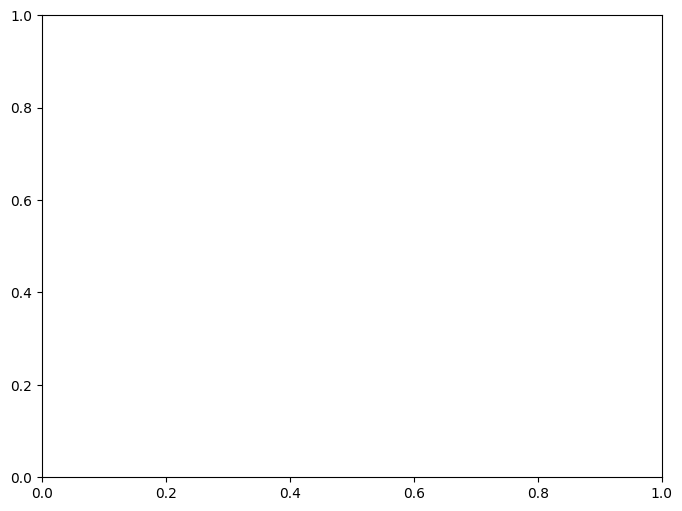

In [ ]:
from matplotlib import pyplot as plt

# Plot the fidelities over time in 2d colormap
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(fidelities_all, aspect='auto', origin='lower', cmap='afmhot')
fig.colorbar(cax)
ax.set_xlabel('#Segments')
ax.set_yticks(jnp.arange(len(labels)))
ax.set_yticklabels(labels)
ax.set_title('Fidelities over Time')

print("scores = ", fidelities_all.mean(axis=1))